In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from toolz import curry
import sys

from sklearn import set_config
set_config(transform_output="pandas")

sys.path.append("..")
pd.set_option("display.max_columns", 500)
plt.rcParams.update({"font.size": 8})

## Processamento da base para cada linha de gêmeos virar duas (uma para cada gêmeo)

In [2]:
df_X = pd.read_csv("twin_pairs_X_3years_samesex.csv").drop(
    columns=["Unnamed: 0.1", "Unnamed: 0", "infant_id_0", "infant_id_1"]
)
df_T = pd.read_csv("twin_pairs_T_3years_samesex.csv").drop(columns=["Unnamed: 0"])
df_Y = pd.read_csv("twin_pairs_Y_3years_samesex.csv").drop(columns=["Unnamed: 0"])

df = pd.concat([df_X, df_T, df_Y], axis=1)

In [3]:
cols_with_index = list(
    map(lambda col: col.split("_")[0], filter(lambda col: "_0" in col, df.columns))
)
cols_without_index = list(
    filter(
        lambda col: not any(col.startswith(stub_name) for stub_name in cols_with_index),
        df.columns,
    )
)

Basicamente tô dando um filtro em cada um e concatenando.

In [4]:
@curry
def return_i_df(i, cols_with_index, cols_without_index, df):
    df_i = (
        df.filter([col + f"_{i}" for col in cols_with_index] + cols_without_index)
        .copy()
        .rename(columns=lambda col: col.replace(f"_{i}", ""))
        .assign(T=i)
    )
    return df_i


return_i = return_i_df(
    cols_with_index=cols_with_index, cols_without_index=cols_without_index, df=df
)

df_final = pd.concat([return_i(i=i) for i in range(2)]).sample(
    frac=1, replace=False, random_state=42
)

In [5]:
df_final.head(3)

,bord,dbirwt,mort,pldel,birattnd,brstate,stoccfipb,mager8,ormoth,mrace,meduc6,dmar,mplbir,mpre5,adequacy,orfath,frace,birmon,gestat10,csex,anemia,cardiac,lung,diabetes,herpes,hydra,hemo,chyper,phyper,eclamp,incervix,pre4000,preterm,renal,rh,uterine,othermr,tobacco,alcohol,cigar6,drink5,crace,data_year,nprevistq,dfageq,feduc6,dlivord_min,dtotord_min,brstate_reg,stoccfipb_reg,mplbir_reg,T
15572,2.0,2268.0,0.0,1.0,1.0,34,37,4,0.0,1,3.0,1,34.0,1.0,1.0,0.0,1.0,10,6,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,89,3.0,1.0,2.0,2.0,2.0,4,4,4.0,0
45206,1.0,2543.0,0.0,1.0,1.0,47,51,5,0.0,1,3.0,1,24.0,1.0,NaN,0.0,1.0,1,5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1,90,NaN,4.0,4.0,6.0,9.0,4,4,3.0,1
12066,1.0,1985.0,0.0,1.0,1.0,26,29,4,0.0,2,3.0,0,26.0,2.0,2.0,NaN,NaN,9,4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,89,0.0,NaN,NaN,3.0,3.0,3,3,3.0,0


___

## Grafo Causal

Grupos das variáveis que definimos.

In [6]:
risk_cols = [
    'alcohol', 'tobacco', 'anemia',
    'diabetes', 'eclamp', 'othermr',
    'cardiac', 'chyper', 'hemo',
    'herpes', 'hydra', 'lung',
    'phyper', 'pre4000', 'preterm',
    'renal', 'rh', 'uterine',
    'incervix'
]

z2_cols = ['dlivord_min', 'dtotord_min']

z3_cols = [
    'birmon', 'adequacy', 'cigar6',
    'drink5', 'gestat10', 'mager8',
    'mpre5', 'nprevistq', 'crace',
    'csex', 'dmar'
]

z4_cols = [
    'bord_0', 'bord_1', 'brstate_reg',
    'data_year', 'stoccfipb_reg'
]

z5_cols = ['birattnd', 'pldel', 'feduc6', 'meduc6']

z6_cols = [
    'brstate', 'dfageq', 'stoccfipb',
    'frace', 'mrace', 'orfath',
    'ormoth', 'mplbir', 'mplbir_reg'
]

all_cols = risk_cols + z2_cols + z3_cols + z4_cols + z5_cols + z6_cols + ["X", "Y"]

In [7]:
from pgmpy.models import BayesianNetwork

graph_model = BayesianNetwork()
graph_model.add_nodes_from(all_cols)
graph_model.add_edges_from(
    [
        ("risk", "X"),
        ("risk", "Y"),
        ("z3", "X"),
        ("z3", "Y"),
        ("z6", "renda"),
        ("renda", "z5"),
        ("renda", "z3"),
        ("z5", "non-observed 1"),
        ("non-observed 1", "X"),
        ("z5", "non-observed 2"),
        ("non-observed 2", "Y"),
        ("z2", "Y"),
    ]
)


Grafo causal:

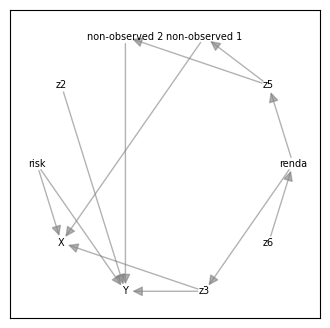

In [8]:
import networkx as nx

plt.figure(figsize=(4, 4))

nx_graph = nx.DiGraph(graph_model.edges())
position_dicts = nx.shell_layout(nx_graph)

nx.draw_networkx_edges(
    nx_graph,
    position_dicts,
    edge_color="gray",
    node_size=100,
    alpha=0.6,
    arrowstyle="-|>",
    arrowsize=15,
)
nx.draw_networkx_labels(nx_graph, position_dicts, font_size=7, font_color="black")
plt.show()

Validando que nosso conjunto satisfaz CB.

In [9]:
from pgmpy.inference import CausalInference

inference = CausalInference(model=graph_model)

proposed_backdoor_set = ["risk", "z3", "z5"]

assert inference.is_valid_backdoor_adjustment_set(
    "X", "Y", proposed_backdoor_set
)

## Estimação

In [10]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [11]:
backdoor_set = risk_cols + z3_cols + z5_cols

def return_XZ_y(df, backdoor_set_list):
    return df.filter(["dbirwt"] + backdoor_set_list), np.array(df.mort)

In [12]:
df_train, df_test = train_test_split(
    df_final,
    test_size=0.2,
    random_state=42,
)

df_test, df_cal = train_test_split(
    df_test,
    test_size=0.2,
    random_state=42,
)

XZ_train, y_train = return_XZ_y(df_train, backdoor_set)
XZ_test, y_test = return_XZ_y(df_test, backdoor_set)
XZ_cal, y_cal = return_XZ_y(df_cal, backdoor_set)

Definindo o modelo a partir da fórmula do ajuste.

In [13]:
from scipy.stats import loguniform
model = make_pipeline(
    ColumnTransformer(
        [
            (
                "target",
                TargetEncoder(random_state=42),
                backdoor_set,
            )
        ],
        remainder="passthrough",
    ),
    RandomizedSearchCV(
        estimator=LGBMClassifier(random_state=42),
        cv=KFold(shuffle=True, random_state=42),
        param_distributions={"learning_rate": loguniform.rvs(random_state=42, a=0.0001, b=1, size=1000), "n_estimators": [50, 100, 200], "num_leaves": [31, 63, 127]},
        scoring="roc_auc",
        n_iter=5,
        random_state=42,
    ),
).fit(XZ_train, y_train)

Performance.

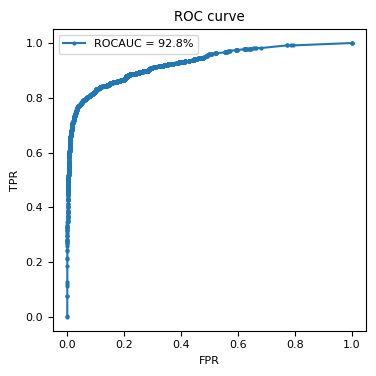

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve

roc = (100 * roc_auc_score(y_test, model.predict_proba(XZ_test)[:, 1])).round(2)
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(XZ_test)[:, 1])

fig, ax = plt.subplots(figsize=(3.8, 3.8))
ax.plot(fpr, tpr, marker="o", markersize=2, label=f"ROCAUC = {roc}%")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("ROC curve")
ax.legend()
plt.tight_layout()

In [15]:
from calibration_stuff import calibration_curve, ece
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV

In [16]:
model_cal = CalibratedClassifierCV(model, cv='prefit', method='isotonic').fit(XZ_cal, y_cal)

In [17]:
ece_original, ece_calibrated = (
    ece(y_test, model.predict_proba(XZ_test)[:, 1]),
    ece(y_test, model_cal.predict_proba(XZ_test)[:, 1]),
)

brier_original, brier_calibrated = (
    brier_score_loss(y_test, model.predict_proba(XZ_test)[:, 1]),
    brier_score_loss(y_test, model_cal.predict_proba(XZ_test)[:, 1])
)

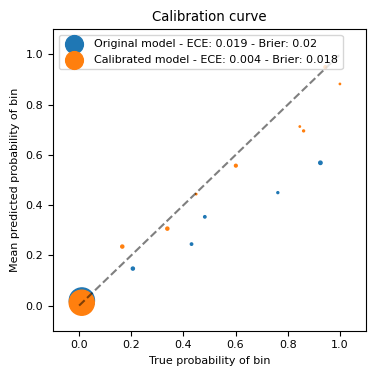

In [18]:
prob_true_original, prob_pred_original, size_bin_original = calibration_curve(y_test, model.predict_proba(XZ_test)[:, 1], n_bins=10)
prob_true_cal, prob_pred_cal, size_bin_cal = calibration_curve(y_test, model_cal.predict_proba(XZ_test)[:, 1], n_bins=10)

fig, ax = plt.subplots(figsize=(3.8, 3.8))
ax.scatter(
    prob_true_original,
    prob_pred_original,
    s=(1 + 0.015*size_bin_original).astype(int),
    label=f"Original model - ECE: {ece_original.round(3)} - Brier: {brier_original.round(3)}",
)
ax.scatter(prob_true_cal,
           prob_pred_cal,
           s=(1 + 0.015*size_bin_cal).astype(int),
           label=f"Calibrated model - ECE: {ece_calibrated.round(3)} - Brier: {brier_calibrated.round(3)}",
)
ax.plot([0, 1], [0, 1], "--k", alpha=0.5)
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_title("Calibration curve")
ax.set_xlabel("True probability of bin")
ax.set_ylabel("Mean predicted probability of bin")
ax.legend(loc="upper left")
plt.tight_layout()

In [19]:
from shap import TreeExplainer

transformed_XZ_train = model.named_steps["columntransformer"].transform(XZ_train)
explainer = TreeExplainer(model.named_steps["randomizedsearchcv"].best_estimator_, data=transformed_XZ_train, model_output='probability')

transformed_XZ_test = model.named_steps["columntransformer"].transform(XZ_test)
shap_values = explainer.shap_values(transformed_XZ_test)

100%|===================| 22820/22830 [00:54<00:00]        

In [20]:
columns_transform_order = list(map(lambda col: col.split("__")[1], transformed_XZ_test.columns))

n_cols_top = 5
assert n_cols_top < XZ_test.shape[1]

df_imp = (
    pd.DataFrame(
        list(zip(columns_transform_order,
                 np.abs(shap_values).mean(axis=0))),
        columns=["cols", "shap_imp"],
    )
    .sort_values(by="shap_imp", ascending=False)
    .assign(cols=lambda df_: df_.cols.head(n_cols_top).to_list() + ["others"] * (XZ_test.shape[1] - n_cols_top))
    .groupby("cols")
    .agg({"shap_imp": np.sum})
    .reset_index()
    .sort_values(by="shap_imp", ascending=False)
    .assign(shap_imp=lambda df_: df_.shap_imp/(df_.shap_imp.sum()))
)

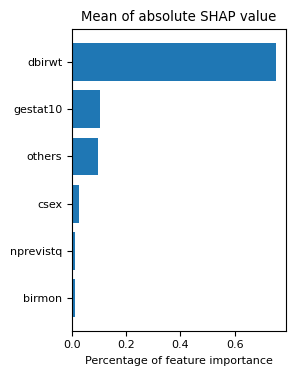

In [21]:
fig, ax = plt.subplots(figsize=(3, 3.8))

ax.barh(range(n_cols_top + 1), df_imp.shap_imp[::-1],
       color="C0", align="center")
ax.set_yticks(range(n_cols_top + 1), df_imp.cols[::-1])
ax.set_title("Mean of absolute SHAP value")
ax.set_xlabel("Percentage of feature importance")
plt.tight_layout()

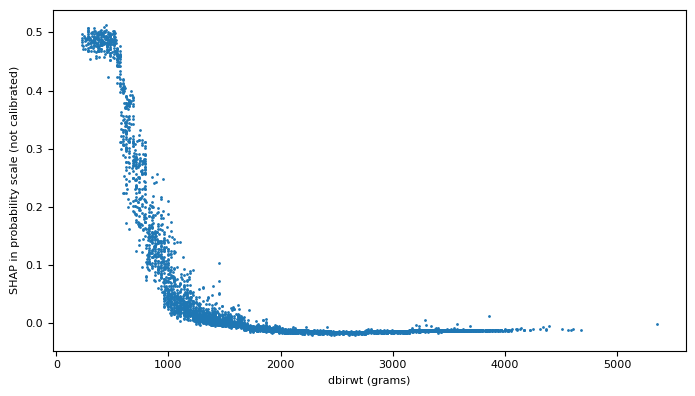

In [22]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.scatter(XZ_test.dbirwt, shap_values[:, columns_transform_order.index("dbirwt")], s=1)
ax.set_ylabel("SHAP in probability scale (not calibrated)")
ax.set_xlabel("dbirwt (grams)")
plt.tight_layout()

Plotando $\mathbb{P}(Y =1 | \textrm{do}(X=x)) = \mathbb{E}(Y | \textrm{do}(X=x))$ em vermelho e $\mathbb{P}(Y = 1 | \textrm{do}(X=x), Z=z) = \mathbb{E}(Y | \textrm{do}(X=x), Z=z)$ em preto. Isso coincide exatamente com o PDP e o ICE.

In [23]:
from sklearn.inspection import partial_dependence

pdp_results = partial_dependence(
    model_cal, XZ_test, "dbirwt", kind="both", grid_resolution=150, percentiles=(0.01, 0.99)
)

pdp_grid = pdp_results["grid_values"][0]
pdp_avg = pdp_results["average"][0]

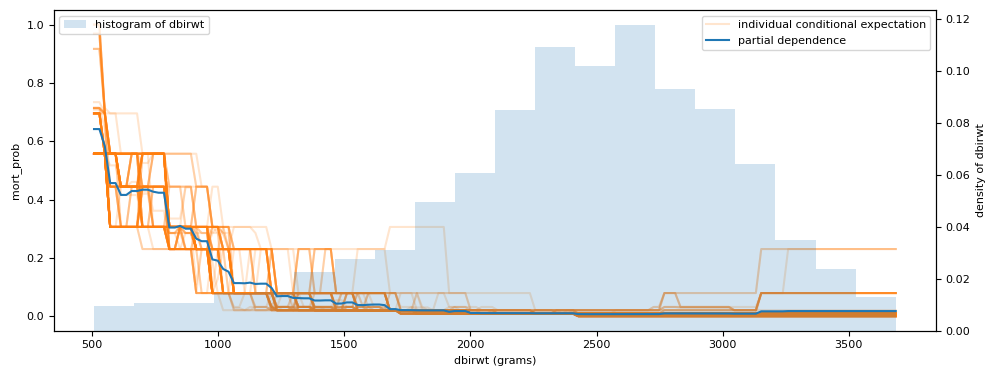

In [24]:
fig, ax = plt.subplots(figsize=(10, 3.8))

min_grid = min(pdp_grid)
max_grid = max(pdp_grid)
twinx = ax.twinx()
twinx.hist(
    XZ_test.dbirwt,
    bins=np.linspace(min_grid, max_grid, 21),
    weights=[1 / df_test.shape[0]] * df_test.shape[0],
    alpha=0.2,
    label="histogram of dbirwt",
)
twinx.set_ylabel("density of dbirwt")
twinx.legend(loc="upper left")

n_ice_plots = 100
index = np.random.RandomState(42).choice(df_test.shape[0], size=n_ice_plots)
for ind_values, label in zip(
    pdp_results["individual"][0][index],
    (n_ice_plots - 1) * ["_nolegend_"] + ["individual conditional expectation"],
):
    ax.plot(pdp_grid, ind_values, "C1", alpha=0.2, label=label)

ax.plot(
    pdp_grid,
    pdp_avg,
    "C0",
    label="partial dependence",
)

ax.set_xlabel("dbirwt (grams)")
ax.set_ylabel("mort_prob")
ax.legend(loc="upper right")

plt.tight_layout()

In [25]:
from scipy.optimize import curve_fit

def avg_model(x, c0, c1, c2, c3, c4):
    return c0 * x**4 + c2 * x**6 + np.exp(c3 * x**2) + c4

def avg_model_derivative(x, c0, c1, c2, c3, c4):
    return 3 * c0 * x**3 + 6 * c2 * x**5 + 2 * c3 * x * np.exp(c3 * x**2)

Para trabalhar com $\mathbb{P}(Y =1 | \textrm{do}(X=x))$ num formato mais amigável, fizemos uma aproximação por $a x^4 + b x^6 + \exp(c x^2) + d$

In [26]:
params_avg_model, _ = curve_fit(avg_model, pdp_grid, pdp_avg, p0=[0, 0, 0, 0, 0], bounds=(-5, np.inf))

print(*[f"c{i}={param}" for i, param in enumerate(params_avg_model)], sep="\n")

c0=-5.600928454082733e-16
c1=-0.04493076878801607
c2=4.244761594128774e-23
c3=-1.8592090001992105e-06
c4=0.023623938741445704


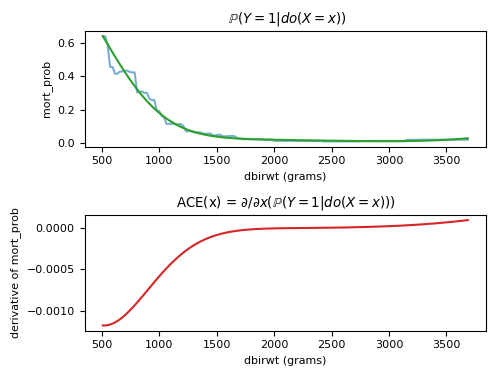

In [27]:
fig, ax = plt.subplots(nrows=2, figsize=(5, 3.8))

ax[0].plot(
    pdp_grid,
    pdp_avg,
    "C0",
    label="partial dependence",
    alpha=0.6,
)

ax[0].plot(
    pdp_grid,
    avg_model(pdp_grid, *params_avg_model),
    "C2",
    label="partial dependence",
)
ax[0].set_title(" $\mathbb{P}(Y =1 | do(X=x))$")
ax[0].set_xlabel("dbirwt (grams)")
ax[0].set_ylabel("mort_prob")

ax[1].plot(
    pdp_grid,
    avg_model_derivative(pdp_grid, *params_avg_model),
    "C3",
    label="partial dependence",
)
ax[1].set_title("ACE(x) = $\partial/\partial x (\mathbb{P}(Y =1 | do(X=x)))$")
ax[1].set_ylabel("derivative of mort_prob")
ax[1].set_xlabel("dbirwt (grams)")
plt.tight_layout()

$x$ que minimiza $\mathbb{E}(Y | \textrm{do}(X=x))$.

In [28]:
print(f"Min of mortality do(X=x) happens when x = {pdp_grid[np.argmin(avg_model(pdp_grid, *params_avg_model))].round(2)} grams.")

print(f"Max decrease of mortality do(X=x) (ACE) happens when x = {pdp_grid[np.argmin(avg_model_derivative(pdp_grid, *params_avg_model))].round(2)} grams.")


Min of mortality do(X=x) happens when x = 2960.71 grams.
Max decrease of mortality do(X=x) (ACE) happens when x = 528.84 grams.


___